In [7]:
from mdm import datas
from sklearn.model_selection import RandomizedSearchCV as _rnd_search
from scipy.stats import uniform as _unif
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as _np
from sklearn.metrics import accuracy_score as _acc
import os as _os
import pickle as _pkl
import logging as _log
import seaborn as sns
from sklearn.metrics import confusion_matrix as _cm
from matplotlib import pyplot as _plt
_logger = _log.getLogger(__name__)
_logger.setLevel(_log.INFO)
sns.set()

In [8]:
raw_data = datas.get("../data/", "dataset.csv")

In [9]:
data = datas.transform(raw_data)

2021-05-14 08:20:53,857 | INFO : log volume
2021-05-14 08:20:53,863 | INFO : log density
2021-05-14 08:20:53,867 | INFO : log weight


In [10]:
X_train, y_train, X_dev, y_dev, X_test, y_test = datas.split(data, 'activity',  pct_test=0.2)

2021-05-14 08:20:55,120 | INFO : train size : 720
2021-05-14 08:20:55,121 | INFO : dev size : 90
2021-05-14 08:20:55,122 | INFO : test size : 90


In [29]:
distributions = {'n_estimators':range(2, 150, 1),
        'min_samples_leaf':range(2, 50, 1),
        'max_features':range(2, len(data.columns), 1),
        'max_samples':range(2, 50, 1)
       }
rf = RandomForestClassifier()
clf_rf = _rnd_search(rf, distributions, random_state=0, n_iter=100, n_jobs=-1)
search_rf = clf_rf.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

0.7861111111111111
{'n_estimators': 93, 'min_samples_leaf': 3, 'max_samples': 45, 'max_features': 2}


In [62]:
distributions = {'n_estimators' : range(2, 300, 1),
        'min_samples_leaf' : range(2, 50, 1),
        'max_features' : range(2, len(data.columns), 1),
        'learning_rate' : [1.0 * 10 ** -i for i in range(7)],
        'max_depth' : range(2, 20, 1)
       }
gb = GradientBoostingClassifier()
clf_gb = _rnd_search(gb, distributions, random_state=0, n_iter=200, n_jobs=-1, cv=4)
search_gb = clf_gb.fit(X_train, y_train)
print(search_gb.best_score_)
print(search_gb.best_params_)

0.8222222222222223
{'n_estimators': 73, 'min_samples_leaf': 6, 'max_features': 4, 'max_depth': 6, 'learning_rate': 0.1}


In [65]:
search_gb.best_estimator_

GradientBoostingClassifier(max_depth=6, max_features=4, min_samples_leaf=6,
                           n_estimators=73)

In [18]:
def save(model, path, name):
    if not _os.path.exists(_os.path.join(path, name)):
        _os.makedirs(_os.path.join(path, name))
    _pkl.dump(model, open(_os.path.join(path, name, 'model.pkl'), 'wb'))
    _logger.info("saved to : {0}".format(_os.path.join(path, name)))
    
def load(path, name):
    model = _pkl.load(open(_os.path.join(path, name, 'model.pkl'), 'rb'))
    _logger.info("loaded from : {0}".format(_os.path.join(path, name)))
    return model

def train(mdl, X_train, y_train, X_dev, y_dev):
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_dev)
    acc = _acc(y_dev,y_pred)
    _logger.info("accuracy : {0}".format(acc))
    return acc, mdl

def evaluate(model, X, y):
    y_pred = model.predict(X)
    acc = _acc(y,y_pred)
    _logger.info("accuracy : {0}".format(acc))
    return acc

def predict(model, X):
    y_pred = model.predict(X)
    return y_pred

def confusion_matrix(y_true, y_preds, labels, save_path=None):
    rst = _cm(y_true, y_preds, normalize='true', labels=labels)
    palette = sns.diverging_palette(20, 220, as_cmap=True)
    _plt.figure(figsize=(10,5))
    sns.heatmap(rst, xticklabels=labels, yticklabels=labels, cmap=palette, annot=True)
    if save_path:
        sp = _os.path.join(save_path, 'confusion_matrix.png')
        _logger.info("saving to : {0}".format(sp))
        _plt.savefig(sp, dpi=400)
        
def feature_importance(feat_imp, feats, save_path=None):
    feature_importance = 100.0 * (feat_imp / feat_imp.max())
    sorted_idx = _np.argsort(feat_imp)
    pos = _np.arange(sorted_idx.shape[0]) + .5
    # plt.subplot(1, 2, 2)
    _plt.figure(figsize=(8, 18))
    _plt.barh(pos, feat_imp[sorted_idx], align='center')
    _plt.yticks(pos, feats[sorted_idx])
    _plt.title('Feature Importance')
    if save_path:
        sp = _os.path.join(save_path, 'feature_importance.png')
        _logger.info("saving to : {0}".format(sp))
        _plt.savefig(sp, dpi=400)
    _plt.show()

In [154]:
models_path = '.'
model_name = 'gb_v1'

In [155]:
save(search_gb.best_estimator_, models_path, model_name)

2021-05-14 01:38:27,709 | INFO : saved to : ./gb_v1


In [12]:
model = load('../models', 'gb_v2')

2021-05-14 08:21:50,265 | INFO : loaded from : ../models/gb_v2


In [13]:
mdl = GradientBoostingClassifier(max_depth=6, max_features=4, min_samples_leaf=6,
                           n_estimators=73)
acc, model = train(mdl, X_train, y_train, X_dev.append(X_test), y_dev.append(y_test))

2021-05-14 08:21:56,335 | INFO : accuracy : 0.8388888888888889


In [15]:
preds = predict(model, X_dev.append(X_test))

In [16]:
test_set = X_dev.append(X_test)
test_set['preds'] = preds
test_set['activity'] = y_dev.append(y_test)

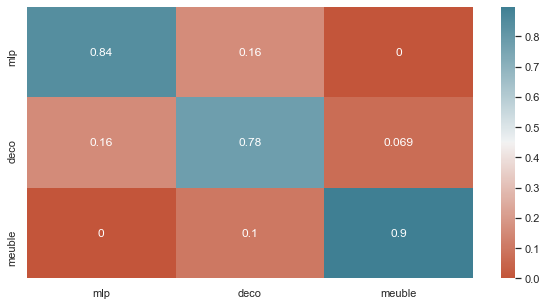

In [19]:
labels = ['mlp', 'deco', 'meuble']
confusion_matrix(test_set.activity, test_set.preds, labels)

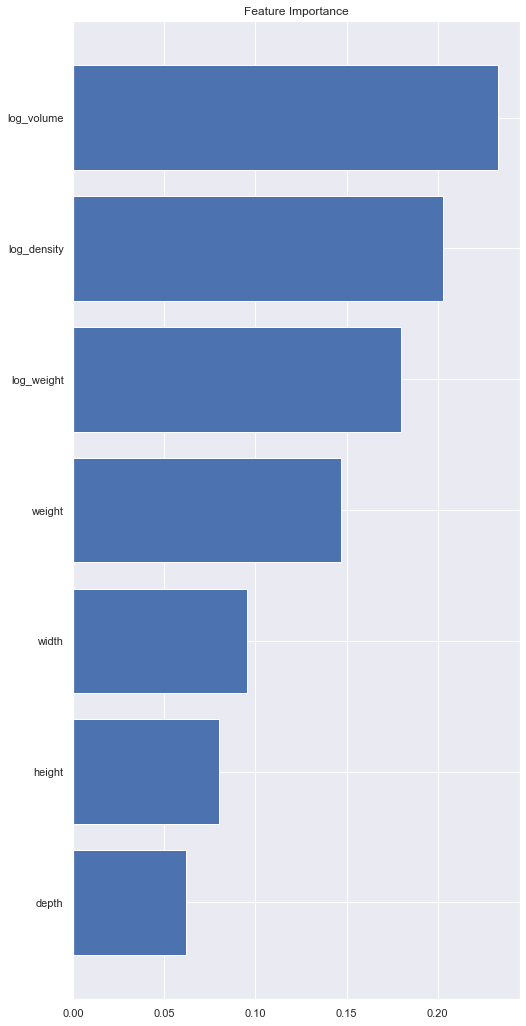

In [21]:
feats = X_train.columns
feature_importance(model.feature_importances_, feats)

In [36]:
test_set['error_analysis'] = test_set.apply(lambda x: 'error' if x['activity'] != x['preds'] else x['activity'], axis=1)

In [38]:
test_set.columns

Index(['height', 'width', 'depth', 'weight', 'log_volume', 'log_density',
       'log_weight', 'preds', 'activity', 'error_analysis'],
      dtype='object')

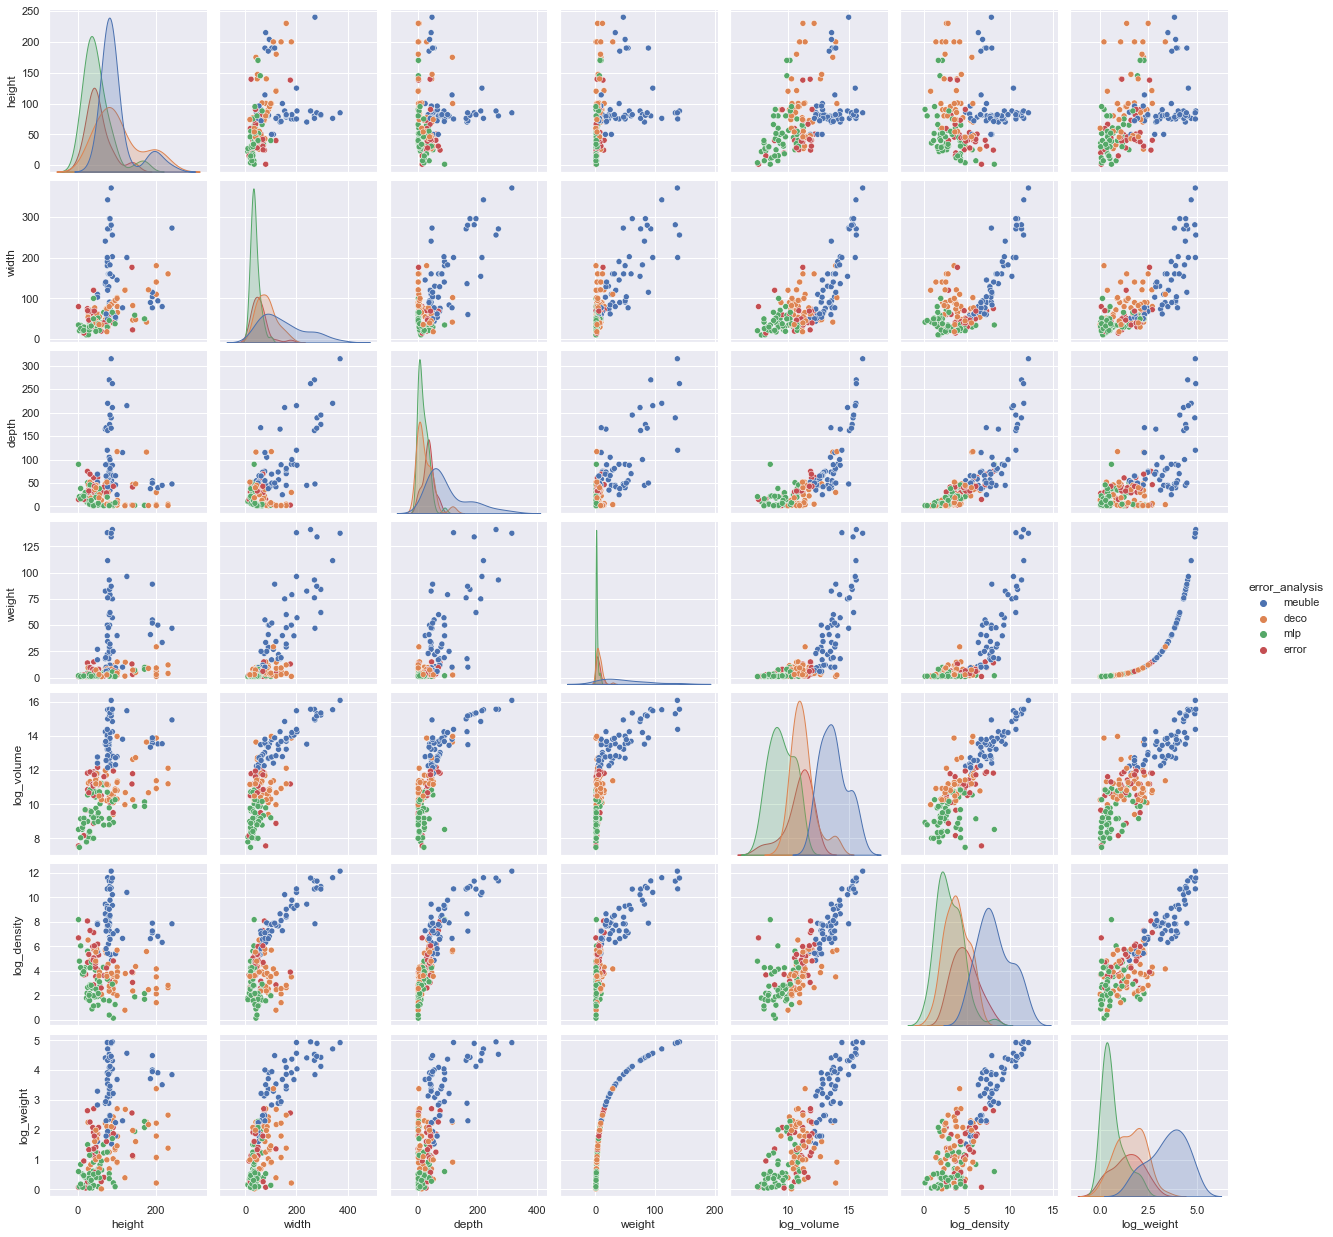

In [43]:
sns.pairplot(test_set[['height', 'width', 'depth', 'weight', 'log_volume', 'log_density', 'log_weight', 'error_analysis']], hue='error_analysis')

Errors are mostly on deco regarding the confusion matrix
This makes sense since it seems in the pair plot that the DECO is in the middle between mlp and meubles where there is the most ambiguity